<a href="https://colab.research.google.com/github/vagmin27/DeepLearning/blob/main/ObjectDetection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Faster-RCNN Framework
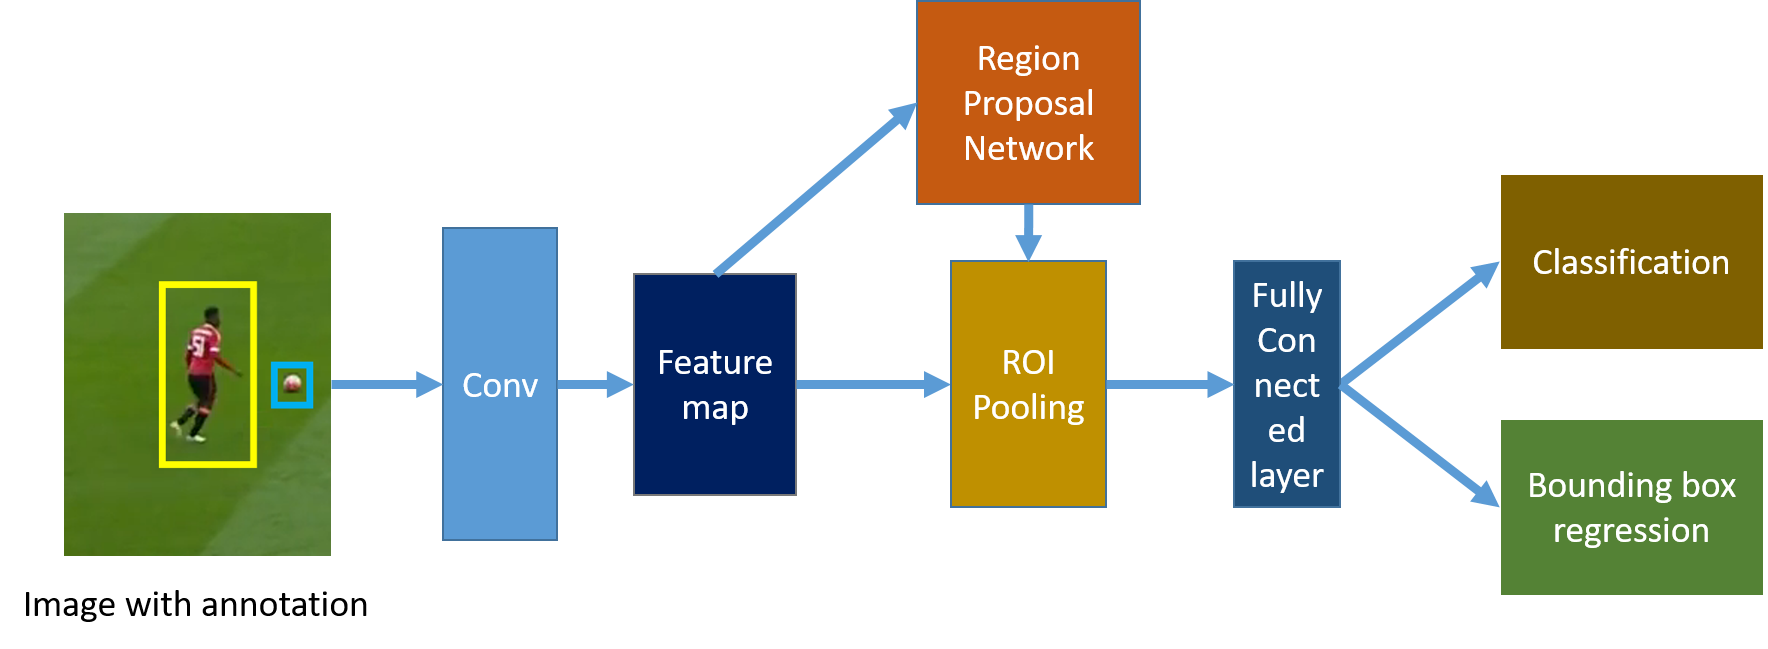

# Basic steps



1. Read images and annotations
2. Extract features from the image
3. Create anchor targets
4. Get regions of the possible objects from the RPN
5. Pass top N locations with high objectness scrores to the Fast R-CNN network
6. Generate proposal targets
7. Calculate rpn_cls_loss and rpn_reg_loss.
8. Calculate roi_cls_loss and roi_reg_loss.




# Major modules that we are going to implement


1.   Feature extraction network
2.   Anchor targets
3. Region proposal network
4. RoI pooling
5. Fast R-CNN
6. Loss functions



In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
%matplotlib inline

# 1. Read images and annotations

In [6]:
# just create a dummy image
image = torch.zeros((1, 3, 800, 800)).float()

# [y1, x1, y2, x2] format
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]])
labels = torch.LongTensor([6, 8])

# 1x1 in feature map -> 16x16 in image
sub_sample = 16

In [7]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img.size())

torch.Size([1, 3, 800, 800])


## Use the first 30 layers of VGG16 to exact features.

Because there are 4 maxpooling layers, (H, W) -> (H//16, W//16)

In [8]:
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)
#print(len(fe))
req_features = fe[:30]
print(req_features)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 144MB/s]


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Convet this into a sequential model

In [11]:
faster_rcnn_feature = nn.Sequential(*req_features)

## Shape of the output of the feature extractor

In [12]:
sample_output = faster_rcnn_feature(dummy_img)
print(sample_output.shape)

torch.Size([1, 512, 50, 50])


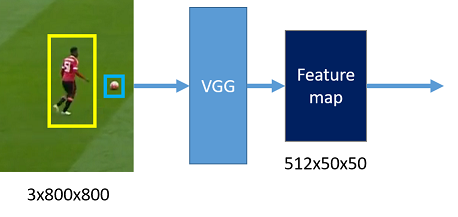

# Anchor boxes

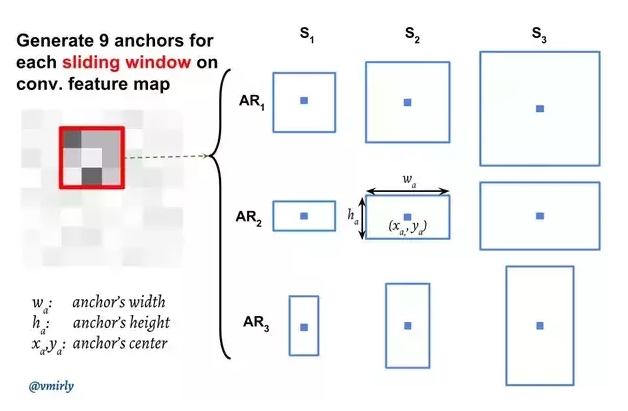

## Assign template anchor boxes
At each point in the feature map, we assign 9 anchor boxes, each has 4 values(y1, x1, y2, x2)
The following step will add the template anchor boxes coors and center coors to get anchor boxes.



In [13]:
# ration = h/w
ratios = [0.5, 1, 2]
# anchor_size
anchor_sizes = [8, 16, 32]
anchor_number = len(ratios) * len(anchor_sizes)
print(f'Total anchor #: {anchor_number}')

Total anchor #: 9


In [16]:
# assign value to anchor_shape

# center coors as for each 16x16 patch in original image
ctr_y = sub_sample / 2
ctr_x = sub_sample / 2

# all 9 anchors in original image
anchors_template = np.zeros((9, 4))


for i, ratio in enumerate(ratios):
    for j, size in enumerate(anchor_sizes):
#         get the h and w in original image
        h = size * np.sqrt(ratio) * sub_sample
        w = size / np.sqrt(ratio) * sub_sample
#         anchor coors in original image
        y1 = -h/2
        x1 = -w/2
        y2 =  h/2
        x2 =  w/2

        anchor = [y1, x1, y2, x2]
        anchors_template[i*len(ratios) + j] = anchor

print(anchors_template)

[[ -45.254834    -90.50966799   45.254834     90.50966799]
 [ -90.50966799 -181.01933598   90.50966799  181.01933598]
 [-181.01933598 -362.03867197  181.01933598  362.03867197]
 [ -64.          -64.           64.           64.        ]
 [-128.         -128.          128.          128.        ]
 [-256.         -256.          256.          256.        ]
 [ -90.50966799  -45.254834     90.50966799   45.254834  ]
 [-181.01933598  -90.50966799  181.01933598   90.50966799]
 [-362.03867197 -181.01933598  362.03867197  181.01933598]]


These are the **anchor locations at the first feature map pixel**, we have to now generate these anchors at all the locations of feature map. Also note that **negitive values** mean that the anchor boxes are outside image dimension. In the later section we will **label them with -1 and remove them when calculating the loss the functions and generating proposals for anchor boxes**. Also Since we got 9 anchors at each location and there **50 * 50** such locations inside an image, We will get **17500 (50 * 50 * 9)** anchors in total. Lets generate other anchors now,

## Generate anchor at all the feature map location

### Generate center coordinates for all the feature map pixels

In [17]:
feature_map_size = 800 // 16

ctr_x_all = np.arange(8, (feature_map_size + 1) * 16 - 8, 16)
ctr_y_all = np.arange(8, (feature_map_size + 1) * 16 - 8, 16)

print(ctr_x_all)
print(ctr_x_all.shape)

[  8  24  40  56  72  88 104 120 136 152 168 184 200 216 232 248 264 280
 296 312 328 344 360 376 392 408 424 440 456 472 488 504 520 536 552 568
 584 600 616 632 648 664 680 696 712 728 744 760 776 792]
(50,)


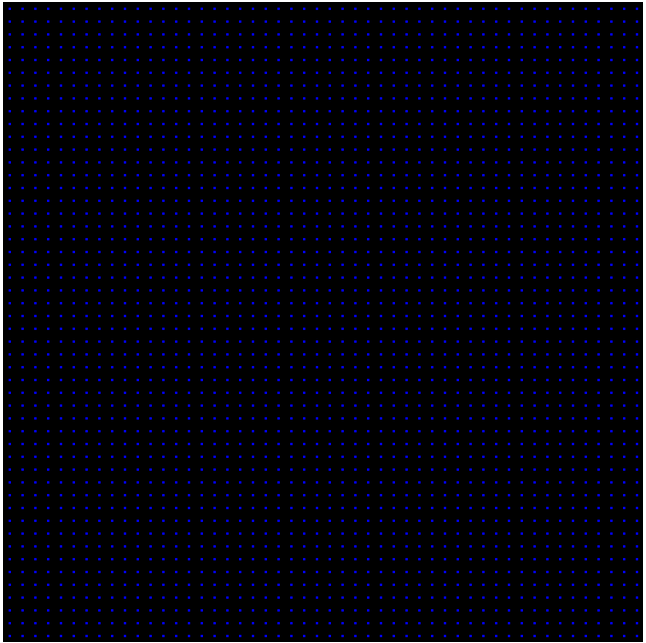

In [18]:
ctr = np.zeros((feature_map_size, feature_map_size, 2), dtype=np.float32)

for y in range(feature_map_size):
    for x in range(feature_map_size):
        ctr[y, x] = np.array([ctr_y_all[y], ctr_x_all[x]])

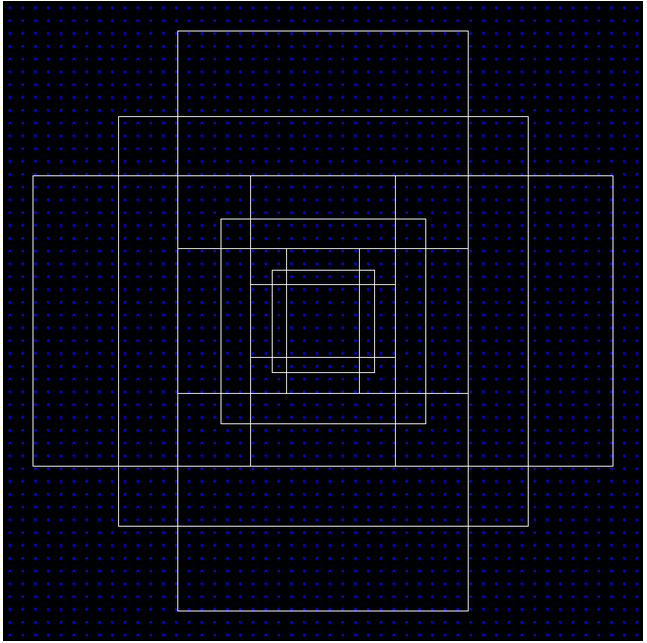

### Add center coors and previous anchor boxes coors

In [19]:
# anchors -> (H//16, W//16, 9, 4)
anchors = np.zeros((feature_map_size, feature_map_size, 9, 4))

In [20]:
for y in range(feature_map_size):
    for x in range(feature_map_size):
#         use broadcast to get anchor boxes corresponding to feature(y, x)
#         two reshape operations
#         (y1, x1, y2, x2) -> ((y1, x1), (y2, x2))
#         ((y1, x1), (y2, x2)) -> (y1, x1, y2, x2)
        anchors[y, x] = (ctr[y, x] + anchors_template.reshape(-1, 2, 2)).reshape(-1, 4)

In [21]:
print(anchors.shape)

(50, 50, 9, 4)


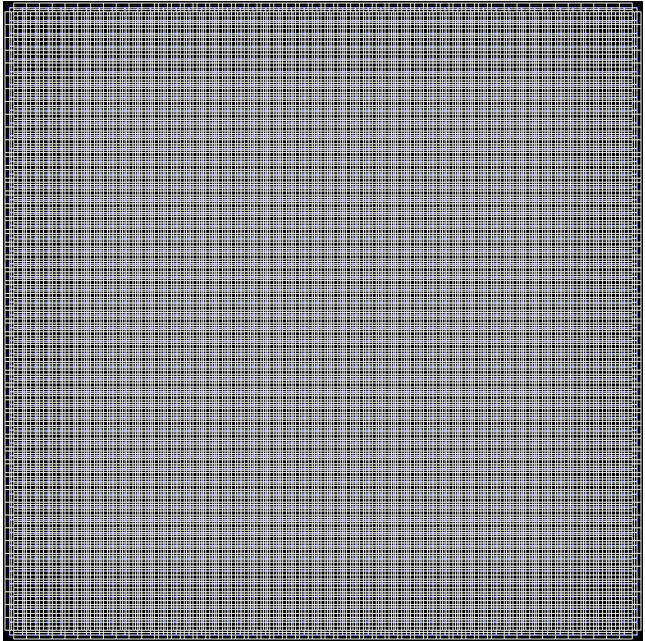

## Assign labels and location of objects to each and every anchor

Now since we have generated all the anchor boxes, we need to look at the objects inside the image and assign them to the specific anchor boxes which contain them. Faster_R-CNN has some guidelines to assign labels to the anchor boxes

We assign a **positive label to two kind of anchors**

a) The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box

b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box.


**Note that single ground-truth object may assign positive labels to multiple anchors.**


c) We assign a **negative label** to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.

d) Anchors that are **neither positive nor negitive** do not contribute to the training objective.

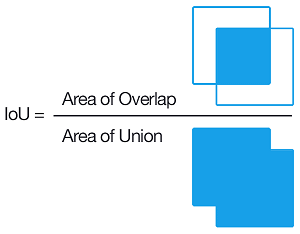

In [22]:
# Remember, we have two ground_truth_bboxes and labels
bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # [y1, x1, y2, x2] format
labels = np.asarray([6, 8], dtype=np.int8) # 0 represents background

### Find the index of all valid anchor boxes

In [23]:
# convert anchors from (H//16, W//16, 4) -> (-1, 4) in order to get the anchors inside the image
# because some anchors have negative coors
anchors = anchors.reshape(-1, 4)

index_inside = np.where((anchors[:, 0] >= 0) &
                       (anchors[:, 1] >= 0) &
                       (anchors[:, 2] <= 800) &
                       (anchors[:, 3] <= 800))[0]

In [24]:
print(index_inside.shape)

(8940,)


### create an empty label array with inside_index shape and fill with -1.

In [25]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)

### create an array with valid anchor boxes

In [26]:
valid_anchors = anchors[index_inside]

### For each anchor box calculate IOU with each ground truth object.

ince we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output.

```
- Find the max of x1 and y1 in both the boxes (xn1, yn1)
- Find the min of x2 and y2 in both the boxes (xn2, yn2)
- Now both the boxes are intersecting only
 if (xn1 < xn2) and (yn2 < yn1)
      - iou_area will be (xn2 - xn1) * (yn2 - yn1)
 else
      - iuo_area will be 0
- similarly calculate area for anchor box and ground truth object
- iou = iou_area/(anchor_box_area + ground_truth_area - iou_area)
```

In [27]:
ious = np.zeros((len(valid_anchors), len(bbox)), dtype=np.float32)

for index_v, valid_anchor in enumerate(valid_anchors):
    y1_v, x1_v, y2_v, x2_v = valid_anchor
    anchor_area = (y2_v - y1_v) * (x2_v - x1_v)

    for index_t, bbox_t in enumerate(bbox):
        y1_t, x1_t, y2_t, x2_t = bbox_t
        bbox_area = (y2_t - y1_t) * (x2_t - x1_t)

        max_y1 = max([y1_v, y1_t])
        max_x1 = max([x1_v, x1_t])
        min_y2 = min([y2_v, y2_t])
        min_x2 = min([x2_v, x2_t])

        if max_x1 < min_x2 and max_y1 < min_y2:
            inter_area = (min_y2 - max_y1) * (min_x2 - max_x1)
            iou = inter_area / (anchor_area + bbox_area - inter_area)
        else:
            iou = 0

        ious[index_v, index_t] = iou
print(ious.shape)

(8940, 2)


In [28]:
print(max(ious[:, 1]))

0.61035156


### Assign labels

Considering the scenarios of a and b, we need to find two things here
- the highest iou for each gt_box and its corresponding anchor box
- the highest iou for each anchor box and its corresponding ground truth box

In [29]:
# case 1
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(len(bbox))]
print(gt_max_ious)

[2262 4096]
[0.68130493 0.61035156]


In [30]:
# case 2
argmax_ious = ious.argmax(axis=1)
print(argmax_ious)

max_ious = ious[np.arange(ious.shape[0]), argmax_ious]
print(max_ious)

[0 0 0 ... 0 0 0]
[0.07360116 0.08134178 0.08159019 ... 0.         0.         0.        ]


**Find the valid anchors which have the gt_max_ious**

In [31]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2262 2269 4096 4104 4112 4120 4370 4378 4386 4394 4644 4652 4660 4668
 4918 4926 4934 4942]


Now we have three arrays
- argmax_ious — Tells which ground truth object has max iou with each anchor.
- max_ious — Tells the max_iou with ground truth object with each anchor.
- gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

In [33]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

In [34]:
label[max_ious < neg_iou_threshold] = 0

In [35]:
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1

### Sample positive and negtive anchors

> we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones.

In [36]:
pos_ratio = 0.5
n_sample = 256

In [37]:
n_pos = pos_ratio * n_sample

In [38]:
# positive samples

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=len(pos_index) - n_pos, replace=False)
    label[disable_index] = -1

In [39]:
# negative samples

n_neg = n_sample - len(np.where(label==1)[0])

neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=len(neg_index) - n_neg, replace=False)
    label[disable_index] = -1

### Assigning locations to anchor boxes


```
t_{x} = (x - x_{a})/w_{a}
t_{y} = (y - y_{a})/h_{a}
t_{w} = log(w/ w_a)
t_{h} = log(h/ h_a)
```
**x, y , w, h** are the groud truth box center co-ordinates which has maxmimum iou with corresponding anchor, width and height. **x_a, y_a, h_a and w_a** and anchor boxes center cooridinates, width and height.

In [40]:
# For each anchor box, find the groundtruth object which has max_iou as base
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

(8940, 4)


In [41]:
height = valid_anchors[:, 2] - valid_anchors[:, 0]
width = valid_anchors[:, 3] - valid_anchors[:, 1]
ctr_y = valid_anchors[:, 0] + height*0.5
ctr_x = valid_anchors[:, 1] + width*0.5

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + base_height*0.5
base_ctr_x = max_iou_bbox[:, 1] + base_width*0.5

In [42]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)


(8940, 4)


### Final labels and locations

In [43]:
# Final labels for all the anchors
anchor_labels = np.empty((len(anchors),), dtype=np.int32)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label

In [44]:
#] Final loc for all the anchors
anchor_locations = np.empty((len(anchors), 4), dtype=np.float32)
anchor_locations.fill(0)
anchor_locations[index_inside] = anchor_locs

In [45]:
print(anchor_labels.shape)
print(anchor_locations.shape)
print(anchor_labels)

(22500,)
(22500, 4)
[-1 -1 -1 ... -1 -1 -1]


#Region Proposal Network


The task of the RPN is to propose possible locations of the objects in an image

To generate region proposals, we **slide a small network over the convolutional feature map output** that we obtained in the feature extraction module. This small network takes as input an n x n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature [512 features]. **This feature is fed into two sibling fully connected layers**
- A box regrression layer
- A box classification layer

In [46]:
mid_channels = 512
in_channels = 512
n_anchor = 9 # Number of anchors at each location in the feature map

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor*4, 1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, n_anchor*2, 1, 1, 0)

## Initialize weights and bias
The paper tells that they initialized these layers with zero mean and 0.01 standard deviation for weights and zeros for base.

In [47]:
# conv1 sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# reg_layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# cls_layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
x = conv1(sample_output) # sample_output is obtained in Section 1.2
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


## Reformat the output

Lets **reformat these a bit and make it align with our anchor targets we designed previously**. We will also find the objectness scores for each anchor box, as this is used to for proposal layer which we will discuss in the next section

In [49]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_scores = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_scores.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])




1.   pred_cls_scores and pred_anchor_locs are the output the RPN network and the losses to updates the weights


2. pred_cls_scores and objectness_scores are used as inputs to the proposal layer, which generate a set of proposal which are further used by RoI network. We will see this in the next section.



# Generating proposals to feed Fast R-CNN network

The proposal function will take the following parameters
- Weather training_mode or testing mode
- nms_thresh
- n_train_pre_nms — number of bboxes before nms during training
- n_train_post_nms — number of bboxes after nms during training
- n_test_pre_nms — number of bboxes before nms during testing
- n_test_post_nms — number of bboxes after nms during testing
- min_size — minimum height of the object required to create a proposal.

The Faster R_CNN says, RPN proposals highly overlap with each other. To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image. After an ablation study, the authors show that NMS does not harm the ultimate detection accuracy, but substantially reduces the number of proposals. After NMS, we use the top-N ranked proposal regions for detection. In the following we training Fast R-CNN using 2000 RPN proposals. During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.

In [50]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

- convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.
- clip the predicted boxes to the image
- Remove predicted boxes with either height or width < threshold (min_size).
- Sort all (proposal, score) pairs by score from highest to lowest.
- Take top pre_nms_topN (e.g. 12000 while training and 300 while testing).
- Apply nms threshold > 0.7
- Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

## convert the loc predictions from the rpn net to [y1, x1, y2, x2] format

In [51]:
anc_height = anchors[:, 2] - anchors[:, 0]
anc_width = anchors[:, 3] - anchors[:, 1]
anc_ctr_y = anchors[:, 0] + anc_height*0.5
anc_ctr_x = anchors[:, 1] + anc_width*0.5

In [52]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(objectness_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
torch.Size([1, 22500])


In [53]:
pred_anchor_locs_np = pred_anchor_locs[0].data.numpy()
objectness_score_np = objectness_scores[0].data.numpy()

dy = pred_anchor_locs_np[:, 0]
dx = pred_anchor_locs_np[:, 1]
dh = pred_anchor_locs_np[:, 2]
dw = pred_anchor_locs_np[:, 3]

ctr_y = dy * anc_height + anc_ctr_y
ctr_x = dx * anc_width + anc_ctr_x
h = np.exp(dh) * anc_height
w = np.exp(dw) * anc_width

In [54]:
# generate roi(region of interest) matrix
roi = np.zeros(pred_anchor_locs_np.shape, dtype=anchors.dtype)

roi[:, 0] = ctr_y - 0.5*h
roi[:, 1] = ctr_x - 0.5*w
roi[:, 2] = ctr_y + 0.5*h
roi[:, 3] = ctr_x + 0.5*w

roi

array([[ -38.81015689,  -80.68943597,   51.80843204,   99.7184214 ],
       [ -79.47920809, -179.72641721,  105.69422917,  190.29724428],
       [-159.33040711, -368.35162978,  195.04135255,  366.01898609],
       ...,
       [ 702.42672806,  744.59238894,  882.53851898,  834.93111741],
       [ 605.03005905,  701.7156467 ,  966.28143597,  884.25329424],
       [ 430.5674948 ,  598.30795905, 1170.09760782,  962.65051128]])

## clip the predicted boxes to the image


In [55]:
img_size = (800, 800)

roi[:, 0:4:2] = np.clip(roi[:, 0:4:2],a_min=0, a_max=img_size[0])
roi[:, 1:4:2] = np.clip(roi[:, 1:4:2],a_min=0, a_max=img_size[1])

roi

array([[  0.        ,   0.        ,  51.80843204,  99.7184214 ],
       [  0.        ,   0.        , 105.69422917, 190.29724428],
       [  0.        ,   0.        , 195.04135255, 366.01898609],
       ...,
       [702.42672806, 744.59238894, 800.        , 800.        ],
       [605.03005905, 701.7156467 , 800.        , 800.        ],
       [430.5674948 , 598.30795905, 800.        , 800.        ]])

## Remove predicted boxes with either height or width < threshold

In [56]:
keep = np.where((h >= min_size) & (w >= min_size))[0]
roi = roi[keep]
score = objectness_score_np[keep]

print(score.shape)

(22500,)


## sort all pairs by score from highest to lowest

In [57]:
order = score.ravel().argsort()[::-1]
print(order)

[ 1345 22045 21621 ... 21602 22484 22034]


In [59]:
## Take top pre_nms_topN
order = order[:n_train_pre_nms]
roi = roi[order]
score = score[order]

print(roi.shape)
print(score.shape)

(12000, 4)
(12000,)


## Apply NMS threshold

- Take all the roi boxes [roi_array]
- Find the areas of all the boxes [roi_area]
- Take the indexes of order the probability score in descending order [order_array]
keep = []
while order_array.size > 0:
  - take the first element in order_array and append that to keep  
  - Find the area with all other boxes
  - Find the index of all the boxes which have high overlap with this box
  - Remove them from order array
  - Iterate this till we get the order_size to zero (while loop)
- Ouput the keep variable which tells what indexes to consider.

In [60]:
y1, x1, y2, x2 = roi.T

areas = (y2-y1+1) * (x2-x1+1)

order = score.argsort()[::-1]

keep = []

while order.size > 0:
    i = order[0]
    keep.append(i)

    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy2 = np.maximum(y2[i], y2[order[1:]])
    xx2 = np.maximum(y2[i], y2[order[1:]])

    h = np.maximum(0.0, yy2-yy1)
    w = np.maximum(0.0, xx2-xx1)

    inter = h*w
    iou = inter / (areas[i] + areas[order[1:]] - inter)

    # IOU threshold
    inds = np.where(iou <= nms_thresh)[0]
    order = order[inds+1]

keep = keep[:n_train_post_nms]
roi = roi[keep]
print(roi.shape)

(1082, 4)


# Proposal targets

The Fast R-CNN network takes the region proposals (obtained from proposal layer in previous section), ground truth boxes and their respective labels as inputs. It will take the following parameters
- n_sample: Number of samples to sample from roi, The default value is 128.
- pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.
- pos_iou_thesh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
- [neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].



In [61]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

## Find the iou of each ground truth object with the region proposals

same as 2.3.4

In [62]:
ious = np.empty((len(roi), 2), dtype = np.float32)
ious.fill(0)

for index, box in enumerate(bbox):
    y1, x1, y2, x2 = box

    inter_y1 = np.maximum(y1, roi[:, 0])
    inter_x1 = np.maximum(x1, roi[:, 1])
    inter_y2 = np.minimum(y2, roi[:, 2])
    inter_x2 = np.minimum(x2, roi[:, 3])

    h = np.maximum(0.0, inter_y2-inter_y1)
    w = np.maximum(0.0, inter_x2-inter_x1)

    eps = np.finfo(np.float32).eps
    iou = h*w / ((y2-y1)*(x2-x1)+(roi[:, 2]-roi[:, 0])*(roi[:, 3]-roi[:, 1]) - h*w + eps)

    ious[:, index] = iou
print(ious.shape)


(1082, 2)


## Assign labels for each proposal

same as 2.3.5

In [63]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 0 0 ... 1 1 0]
[0.         0.         0.0806924  ... 0.01930615 0.02269494 0.        ]


In [64]:
gt_roi_label = labels[gt_assignment]

## Sample pos and neg samples

same as 2.3.6

- Select the foreground rois as per the pos_iou_thesh. We also want only n_sample x pos_ratio (128 x 0.25 = 32) foreground samples. So incase if we get less than 32 positive samples we will leave it as it is, Incase if we get more than 32 foreground samples, we will sample 32 samples from the positive samples. This is done using the following code.

In [65]:
pos_index = np.where(max_iou>=pos_iou_thresh)[0]
pos_roi_per_this_image = n_sample * pos_ratio
pos_roi_per_this_image = int(min(pos_roi_per_this_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index.shape)

0
(0,)


In [66]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou > neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image

if neg_index.size > 0:
    neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index.shape)

128
(128,)


## Gather positve samples index and negitive samples index, their respective labels and region proposals

In [67]:
keep_index = np.append(pos_index, neg_index)
print(len(keep_index))
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

128
(128, 4)


## Pick the ground truth objects for these sample_roi and later parameterize

same as 2.3.7

In [68]:
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 2]
ctr_y = sample_roi[:, 0] + height*0.5
ctr_x = sample_roi[:, 1] + width*0.5

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + base_height*0.5
base_ctr_x = bbox_for_sampled_roi[:, 1] + base_width*0.5



- We will use the following formulation

```
t_{x} = (x - x_{a})/w_{a}
t_{y} = (y - y_{a})/h_{a}
t_{w} = log(w/ w_a)
t_{h} = log(h/ h_a)
```

In [69]:
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height/height)
dw = np.log(base_width/width)

gt_roi_locs = np.stack((dy, dx, dh, dw), axis=1)
print(gt_roi_locs)

[[ 3.83711141e-01 -5.96707505e-01 -8.16772214e-01 -5.52054148e-01]
 [ 1.97127660e-01 -6.27559581e-01 -9.43203511e-01 -2.00623565e-01]
 [ 1.34827107e-01 -6.46774619e-01 -9.43203511e-01 -6.03089204e-02]
 [ 5.52120406e-01 -3.42304075e-01 -6.42339618e-01 -7.26914140e-01]
 [ 4.62811229e-01 -3.81557494e-01 -7.31045091e-01 -6.53756250e-01]
 [ 4.65912209e-01 -6.28627298e-01 -2.50990720e-01 -6.70997183e-01]
 [ 5.43996709e-01 -6.14128316e-01 -6.50090844e-01 -7.34425942e-01]
 [ 4.16145117e-01 -3.70227164e-01 -7.80727683e-01 -5.97153622e-01]
 [ 1.36670603e-01 -6.02899838e-01 -1.14465005e+00  1.52384384e-01]
 [-5.29965668e-01 -8.72114581e-01 -2.50990720e-01  3.91285577e-01]
 [ 2.08879209e-01 -1.38034918e-01 -1.03721732e+00 -7.88402715e-02]
 [ 6.57409863e-01 -5.68677996e-01 -5.46962549e-01 -8.20662114e-01]
 [-1.14681083e+00 -1.03031309e+00  3.93336623e-01             nan]
 [ 2.08879209e-01 -4.39203389e-01 -1.03721732e+00 -1.64365353e-01]
 [ 1.89333054e-01 -1.09136418e-01 -1.06517792e+00 -2.02941633e

/tmp/ipython-input-4117239194.py:4: RuntimeWarning: invalid value encountered in log
  dw = np.log(base_width/width)


# Fast R-CNN

Fast R-CNN used ROI pooling to extract features for each and every proposal suggested by selective search (Fast RCNN) or Region Proposal network (RPN in Faster R- CNN).

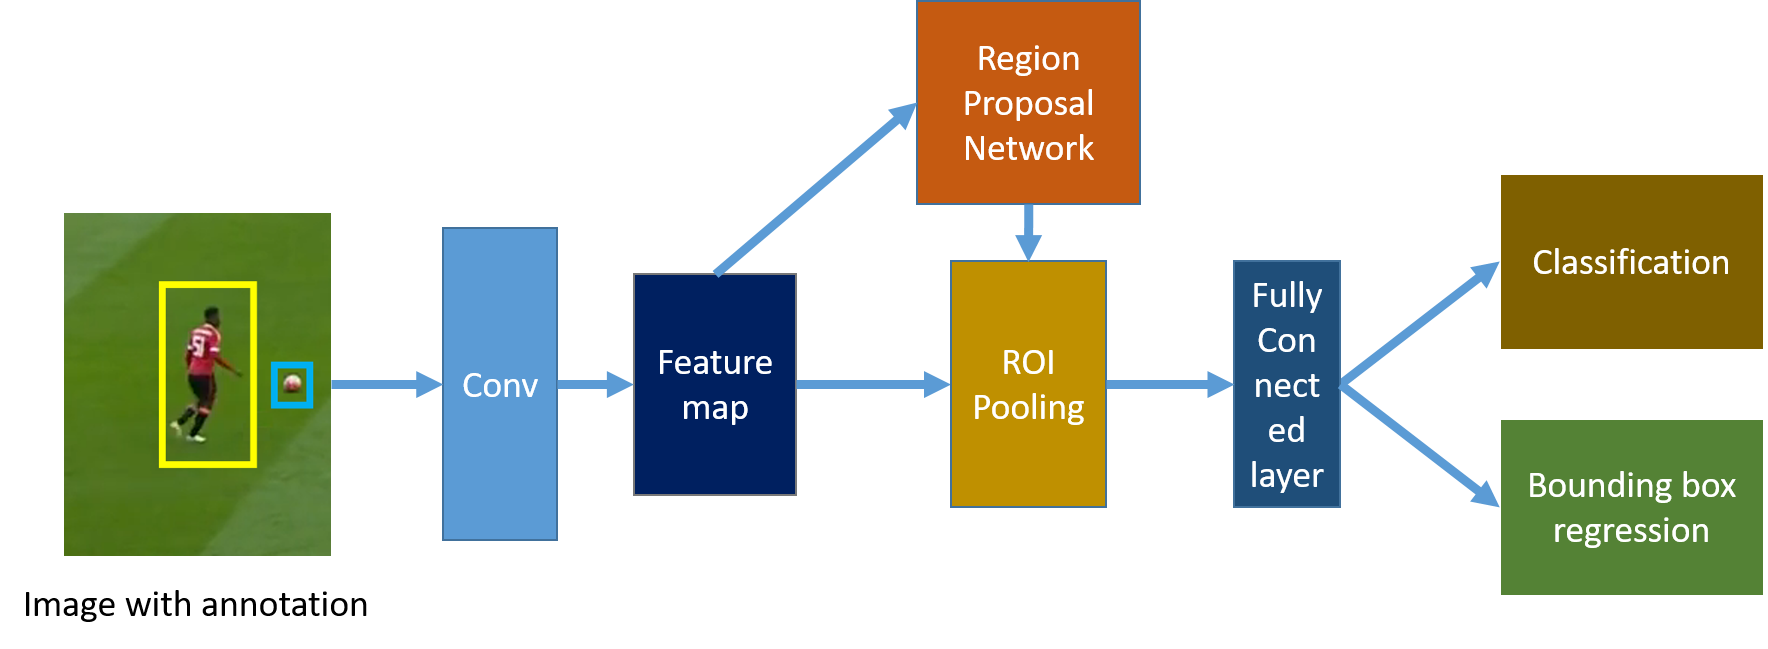

Region of interest pooling (also known as RoI pooling) purpose is to perform max pooling on inputs of non-uniform sizes to obtain fixed-size feature maps (e.g. 7×7). This layer takes two inputs

- A fixed-size feature map obtained from a deep convolutional network with several convolutions and max-pooling layers
- An Nx5 matrix of representing a list of regions of interest, where N is the number of RoIs. The first column represents the image index and the remaining four are the co-ordinates of the top left and bottom right corners of the region.

What does the RoI pooling actually do? For every region of interest from the input list, it takes a section of the input feature map that corresponds to it and scales it to some pre-defined size (e.g., 7×7). The scaling is done by:
- Dividing the region proposal into equal-sized sections (the number of which is the same as the dimension of the output)
- Finding the largest value in each section
- Copying these max values to the output buffer

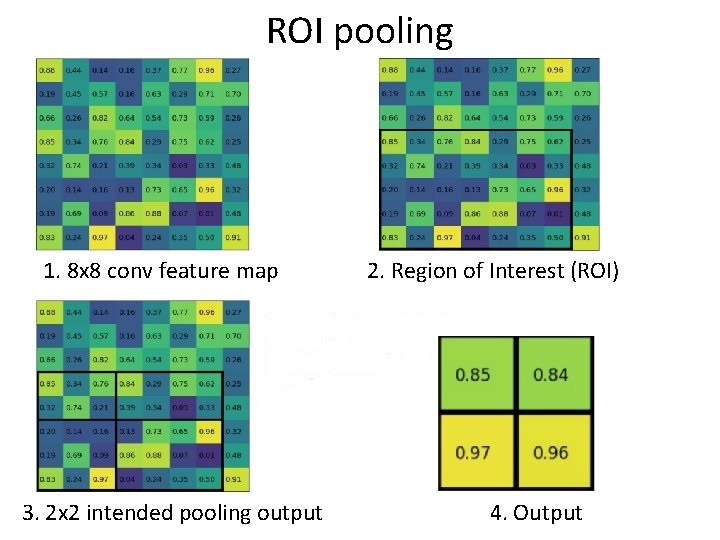

In [70]:
rois = torch.from_numpy(sample_roi).float()
# roi_indices is 0 because there is only one image
roi_indices = 0 * np.ones((len(rois), 1), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128, 1])


concat rois and roi_indices, so that we get the tensor with shape [N, 5] (index, y1, x1, y2, x2)

In [71]:
indices_and_rois = torch.cat([roi_indices, rois], dim=1)
print(indices_and_rois.shape)

torch.Size([128, 5])


Now we need to pass this array to the roi_pooling layer. We will briefly discuss the workings of it here. The sudo code is as follows

- Multiply the dimensions of rois with the sub_sampling ratio (16 in this case)
- Empty output Tensor
- Take each roi
    - subset the **feature map** based on the roi dimension
    - Apply AdaptiveMaxPool2d to this subset Tensor.
    - Add the outputs to the output Tensor
- Empty output Tensor goes to the network

We will define the size to be 7 x 7 and define adaptive_max_pool

## ROI layer

In [72]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveAvgPool2d(size)

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)
rois = rois.long()
num_rois = rois.size(0)
print(num_rois)

128


In [73]:
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = sample_output[..., roi[1]:roi[3]+1, roi[2]:roi[4]+1]
    output.append(adaptive_max_pool(im))

output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


In [74]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.size())

torch.Size([128, 25088])


# Classifiction and Regression heads

Now this will be the input to a classifier layer, which will further brach out to a classification head and regression head as shown in the diagram below. lets define the network

In [75]:
roi_head_classifier = nn.Sequential(nn.Linear(25088, 4096),
                                    nn.Linear(4096, 4096))

# loc
cls_loc = nn.Linear(4096, 21*4) # (VOC 20 classes + 1 background. Each will have 4 co-ordinates)

cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

# cls
score = nn.Linear(4096, 21)

In [76]:
k = roi_head_classifier(k)
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 84]) torch.Size([128, 21])


**roi_cls_loc** and **roi_cls_score** are two ouput tensors from which we can get actual bounding boxes. Now, we are going to compute the losses for both the RPN and Fast RCNN networks. This will complete the Faster R-CNN implementation.

# Loss functions

We have two networks, RPN and Fast-RCNN, which further have two outputs each (Regression head, and classification head). The Loss function for both the network is defined as,


Faster RCNN loss

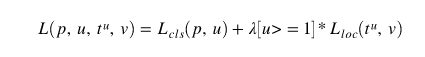



## RPN Loss
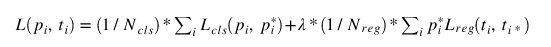

where `p_{i}` is the predicted class label and `p_{i}^*` is the actual class score. `t_{i}` and `t_{i}^*` are the predicted co-oridinates and actual co-ordinates. The ground-truth label `p_{i}^*` is 1 if the the anchor is positive and 0 if the anchor is negative. We will see how this is done in Pytorch.

In [77]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [78]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

pred_cls_scores and anchor_labels are the predited objectness score and actual objectness score of the RPN network. We will use the following loss functions for Regression and classification respectively.


**For classification we use cross-entropy loss**
Cross Entropy Loss

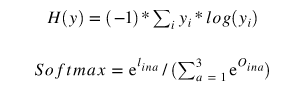

In [79]:
# F.cross_entropy already average the loss for each batch
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6942, grad_fn=<NllLossBackward0>)


**For Regression we use smooth L1 loss** as defined in the Fast RCNN paper,
Smooth L1 Loss

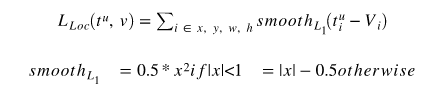

They used L1 loss instead of L2 loss because the values of predicted regression head of RPN are not bounded. **Regression loss is also applied to the bounding boxes which have positive label**

In [80]:
mask = gt_rpn_score > 0
print(mask.shape)

torch.Size([22500])


Now take those bounding boxes which have positve labels

In [81]:
mask_loc_preds = rpn_loc[mask]
mask_loc_targets = gt_rpn_loc[mask]
print(mask_loc_preds.shape, mask_loc_preds.shape)

torch.Size([18, 4]) torch.Size([18, 4])


In [82]:
x = torch.abs(mask_loc_targets-mask_loc_preds)
rpn_loc_loss = (x<1).float() * 0.5 * x**2 + (x>1).float()*(x-0.5)
print(rpn_loc_loss.sum())

tensor(1.1845, grad_fn=<SumBackward0>)


Combining both the rpn_cls_loss and rpn_reg_loss

In [83]:
rpn_lambda = 10
N_reg = (gt_rpn_score>0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum()/N_reg
rpn_loss = rpn_cls_loss + rpn_lambda*rpn_loc_loss

print(rpn_loss)

tensor(1.3523, grad_fn=<AddBackward0>)


## Fast R-CNN loss

The Fast R-CNN loss functions are also implemented in the same way with few tweaks.

We have the following variables

In [84]:
#predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

torch.Size([128, 84])
torch.Size([128, 21])


In [85]:
#actual
gt_roi_loc = torch.from_numpy(gt_roi_locs).float()
gt_roi_label = torch.from_numpy(gt_roi_labels).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

torch.Size([128, 4]) torch.Size([128])


In [86]:
#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1)
print(roi_cls_loss)

tensor(3.0426, grad_fn=<NllLossBackward0>)


In [87]:
#Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 21, 4])
torch.Size([128, 4])


In [88]:
mask = gt_roi_label>0
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)

print(mask_loc_preds.shape, mask_loc_targets.shape)

torch.Size([0, 4]) torch.Size([0, 4])


In [89]:
x = torch.abs(mask_loc_preds - mask_loc_targets)
roi_loc_loss = (x<1).float()*0.5*x**2 + (x>=1).float()*(x-0.5)

- total roi loss

In [90]:
roi_lambda = 10.
N_reg = (gt_roi_label>0).float().sum()
if (N_reg == 0):
  N_reg = 1

roi_loc_loss = roi_loc_loss.sum() / N_reg
roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss
print(roi_cls_loss)
print(roi_loc_loss)
print(roi_loss)

tensor(3.0426, grad_fn=<NllLossBackward0>)
tensor(0., grad_fn=<DivBackward0>)
tensor(3.0426, grad_fn=<AddBackward0>)


## Total loss

In [91]:
total_loss = rpn_loss + roi_loss

In [92]:
print(total_loss)

tensor(4.3949, grad_fn=<AddBackward0>)


# Train the network

```
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for epoch in range(no_of_epochs):    
    for i, data in enumerate(train_loader, 0):
        img, gt_box, labels = data

        rpn_loss, roi_loss, pred_class, pred_box = single_image_pipeline(img.to(device), gt_box, labels, True)
        total_loss = rpn_loss + roi_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
```

